In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
from math import sqrt
from scipy.stats import norm
from scipy.stats import uniform
import cmath #for complex numbers
from scipy.integrate import quad #for numerical integration
from sklearn.preprocessing import MinMaxScaler
import scipy
import time
import multiprocessing

In [8]:
num_model_parameters = 3
num_strikes = 16
num_maturities = 16


num_input_parameters = 5
num_output_parameters = 1
learning_rate = 0.0001
num_steps = 5
batch_size = 5
num_neurons = 100

#initial values
S0 = 1.0
V0 = 0.1
r = 0.05


contract_bounds = np.array([[0.6*S0,1.2*S0],[1,10]]) #bounds for K,T
model_bounds = np.array([[0.01,0.15],[0.2,0.8],[-1,0]]) #bounds for alpha,beta,rho, make sure alpha>0, beta,rho \in [0,1]

"""
Note: The grid of stirkes and maturities is equidistant here put could be choosen differently for real world application.
Note: For the code below to striktly follow the bounds specified above make sure that *_distance x num_* is less than half the distance from the highest to lowest * (* = strikes/maturities). 
"""
maturities_distance = (contract_bounds[1,1]-contract_bounds[1,0])/(2*num_maturities) 
strikes_distance = (contract_bounds[0,1]-contract_bounds[0,0])/(2*num_strikes)

strikes = np.linspace(contract_bounds[0,0],contract_bounds[0,0]+num_strikes*strikes_distance,num_strikes)
maturities = np.linspace(contract_bounds[1,0],contract_bounds[1,0]+num_maturities*maturities_distance,num_maturities)

In [9]:
X = tf.placeholder(tf.float32, [None, num_input_parameters])
y = tf.placeholder(tf.float32, [None, num_output_parameters])

In [10]:
def corr_brownian_motion(n, T, dim, rho):
    dt = T/n

    dW1 = norm.rvs(size=(dim,n+1) , scale=sqrt(dt))
    dW2 = rho * dW1 + np.sqrt(1 - np.power(rho ,2)) * norm.rvs(size=(dim,n+1) , scale=sqrt(dt))
        
    W1 = np.cumsum(dW1, axis=-1)
    W2 = np.cumsum(dW2, axis=-1)
 
    return W1,W2

def euler_maruyama(mu,sigma,T,x0,W):
    dim = W.shape[0]
    n = W.shape[1]-1
    Y = np.zeros((dim,n+1))
    dt = T/n
    sqrt_dt = np.sqrt(dt)
    for l in range(dim):
        Y[l,0] = x0
        for i in range(n):
            Y[l,i+1] = Y[l,i] + np.multiply(mu(Y[l,i],l,i),dt) + sigma(Y[l,i],l,i)*sqrt_dt*(W[l,i+1]-W[l,i])
    
    return Y

def sabr(alpha,beta,T,W,Z,V0,S0):
    #print(beta)
    #assert(beta>0 and beta<1)

    def mu2(V,i,k):
        return 0.0
    
    def sigma2(V,i,k):
        return np.multiply(alpha,V)
    
    V = euler_maruyama(mu2,sigma2,T,V0,Z)
    
    def mu1(S,i,k):
        return 0.0
    
    def sigma1(S,i,k):
        return np.multiply(V[i,k],np.power(np.maximum(0.0,S),beta))
    
    S = euler_maruyama(mu1,sigma1,T,S0,W)
    
    return S,V

def reverse_transform_X(X_scaled):
    X = np.zeros(X_scaled.shape)
    for i in range(num_model_parameters):
        X[:,i] = X_scaled[:,i]*(model_bounds[i][1]-model_bounds[i][0]) + model_bounds[i][0]
    for i in range(2):
        X[:,num_model_parameters+i] = X_scaled[:,num_model_parameters+i]*(contract_bounds[i][1]-contract_bounds[i][0]) + contract_bounds[i][0]
    return X

def price_pred(alpha,beta,rho,n,dim,T,K,V0,S0):
    W,Z = corr_brownian_motion(n,T,dim,rho)
    S,V = sabr(alpha,beta,T,W,Z,V0,S0)
    S_T = S[:,n]
    P = np.exp(-r*T) * np.mean(np.maximum(S_T-K,np.zeros(dim)))
    
    return P

def implied_vol(P,K,T):
    def f(sigma):
        dplus = (np.log(S0 / K) + (r  + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        dminus = (np.log(S0 / K) + (r  - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        
        return S0 * norm.cdf(dplus, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(dminus, 0.0, 1.0) - P
     
    return scipy.optimize.brentq(f, 0, 1)

def BS_call_price(sigma,K,T):
    dplus = (np.log(S0 / K) + (r  + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    dminus = (np.log(S0 / K) + (r  - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

    return S0 * norm.cdf(dplus, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(dminus, 0.0, 1.0)

def next_batch_sabr_EM_train(batch_size,contract_bounds,model_bounds):
    X_scaled = np.zeros((batch_size,num_input_parameters))
    y = np.zeros((batch_size,num_output_parameters))

    X_scaled[:,0] = uniform.rvs(size=batch_size) #alpha
    X_scaled[:,1] = uniform.rvs(size=batch_size) #beta
    X_scaled[:,2] = uniform.rvs(size=batch_size) #rho
    X_scaled[:,3] = uniform.rvs(size=batch_size) #stirkes
    X_scaled[:,4] = uniform.rvs(size=batch_size) #maturities

    X = reverse_transform_X(X_scaled)
    
    n = 100
    dim = 10000
    for i in range(batch_size): 
        #P = price_pred(X[i,0],X[i,1],X[i,2],n,dim,X[i,4],np.log(X[i,3]),V0,S0)
        #y[i,0] = implied_vol(P,X[i,3],X[i,4])
        y[i,0] = price_pred(X[i,0],X[i,1],X[i,2],n,dim,X[i,4],X[i,3],V0,S0)
    return X_scaled,y
    

In [5]:
%timeit next_batch_sabr_EM_train(1,contract_bounds,model_bounds)


14.9 s ± 77.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
#Layers
hidden1 = fully_connected(X, num_neurons, activation_fn=tf.nn.softplus)
bn1 = tf.nn.batch_normalization(hidden1, 0, 1, 0, 1, 0.000001)
hidden2 = fully_connected(bn1, num_neurons, activation_fn=tf.nn.softplus)
bn2 = tf.nn.batch_normalization(hidden2, 0, 1, 0, 1, 0.000001)
hidden3 = fully_connected(bn2, num_neurons, activation_fn=tf.nn.softplus)
bn3 = tf.nn.batch_normalization(hidden3, 0, 1, 0, 1, 0.000001)

outputs = fully_connected(bn3, num_output_parameters, activation_fn=None)

In [12]:
#Loss Function
loss = tf.reduce_mean(tf.sqrt(tf.square(outputs - y)))  # MSE

#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

In [86]:
num_cpu = multiprocessing.cpu_count()
config = tf.ConfigProto(device_count={ "CPU": num_cpu },
                                        inter_op_parallelism_threads=num_cpu,
                                        intra_op_parallelism_threads=2,
                                        )

with tf.Session(config=config) as sess:
    sess.run(init)
    
    for iteration in range(num_steps):
        
        X_batch,Y_batch = next_batch_sabr_EM_train(batch_size,contract_bounds,model_bounds)
        sess.run(train,feed_dict={X: X_batch, y: Y_batch})
        
        if iteration % 1 == 0:
            
            rmse = loss.eval(feed_dict={X: X_batch, y: Y_batch})
            print(iteration, "\tRMSE:", rmse)
    
    saver.save(sess, "./models/sabr_dnn_m2")

0 	RMSE: 2.129257
1 	RMSE: 1.898339
2 	RMSE: 2.064448
3 	RMSE: 1.8861654
4 	RMSE: 1.9099836


In [13]:
def predict_theta(prices_true):   
    
    def NNprediction(theta,maturities,strikes):
        res = np.zeros((1,num_maturities,num_strikes))
        x = np.zeros((1,num_input_parameters))
        
        x[0,0:3] = theta
       
        for i in range(num_maturities):
            for j in range(num_strikes):
                x[0,3] = maturities[i]
                x[0,4] = strikes[j]
                res[0,i,j] = sess.run(outputs,feed_dict={X: x})
        return res
    def NNgradientpred(theta,maturities,strikes):
        x = np.zeros((1,num_input_parameters))
        
        x[0,0:3] = theta
       
        grad = np.zeros((num_model_parameters,num_maturities,num_strikes))
        
        delta = 0.000001
        for i in range(num_model_parameters):
            h = np.zeros((1,num_input_parameters))
            h[0,i] = delta
            for j in range(num_maturities):
                for k in range(num_strikes):
                    x[0,3] = maturities[j]
                    x[0,4] = strikes[k]
                    #two point gradient
                    #grad[i] = (sess.run(outputs,feed_dict={X: x+h}) - sess.run(outputs,feed_dict={X: x-h}))/2/delta

                    #four point gradient
                    grad[i,j,k] = (-sess.run(outputs,feed_dict={X: x+2*h})+8*sess.run(outputs,feed_dict={X: x+h})-8*sess.run(outputs,feed_dict={X: x-h}) +sess.run(outputs,feed_dict={X: x-2*h}))/12/delta

        return np.mean(np.mean(grad,axis=1),axis=1)

    def CostFuncLS(theta,maturities,strikes):
        
        return np.sqrt(np.mean(np.mean(np.power((NNprediction(theta,maturities,strikes)-prices_true)[0],2),axis=0),axis=0))


    def JacobianLS(theta,maturities,strikes):

        return NNgradientpred(theta,maturities,strikes)

    with tf.Session() as sess:                          
        saver.restore(sess, "./models/sabr_dnn_m2")      
        
        init = [model_bounds[0,0]+uniform.rvs()*(model_bounds[0,1]-model_bounds[0,0]),model_bounds[1,0]+uniform.rvs()*(model_bounds[1,1]-model_bounds[1,0]),model_bounds[2,0]+uniform.rvs()*(model_bounds[2,1]-model_bounds[2,0])]
        bnds = ([model_bounds[0,0],model_bounds[1,0],model_bounds[2,0]],[model_bounds[0,1],model_bounds[1,1],model_bounds[2,1]])


        I=scipy.optimize.least_squares(CostFuncLS,init,bounds=bnds,gtol=1E-25,xtol=1E-25,verbose=1,args=(maturities,strikes))

    theta_pred = I.x
    
    return theta_pred

In [14]:
def prices_grid(theta):
    prices_true = np.zeros((1,num_maturities,num_strikes))
    n = 100
    dim = 200
    for i in range(num_maturities):
        for j in range(num_strikes):        
            prices_true[0,i,j] = price_pred(theta[0],theta[1],theta[2],n,dim,maturities[i],strikes[j],V0,S0)
    return prices_true

In [89]:
theta_true = [0.1,0.5,-0.5]
prices_true = prices_grid(theta_true)

In [90]:
theta_pred = predict_theta(prices_true)

INFO:tensorflow:Restoring parameters from ./models/sabr_dnn_m2
`xtol` termination condition is satisfied.
Function evaluations 9, initial cost 5.2138e-01, final cost 5.2131e-01, first-order optimality 4.73e-14.


In [91]:
print(theta_true)
print(theta_pred)

[0.1, 0.5, -0.5]
[ 0.15        0.57560598 -0.93094963]


In [92]:
prices_true = np.zeros((num_maturities,num_strikes))
prices_pred = np.zeros((num_maturities,num_strikes))
init = [model_bounds[0,0]+uniform.rvs()*(model_bounds[0,1]-model_bounds[0,0]),model_bounds[1,0]+uniform.rvs()*(model_bounds[1,1]-model_bounds[1,0]),model_bounds[2,0]+uniform.rvs()*(model_bounds[2,1]-model_bounds[2,0])]
prices_trash = np.zeros((num_maturities,num_strikes))
n = 100
dim = 1000
for i in range(num_maturities):
    for j in range(num_strikes):        
        prices_true[i,j] = price_pred(theta_true[0],theta_true[1],theta_true[2],n,dim,maturities[i],strikes[j],V0,S0)
        prices_pred[i,j] = price_pred(theta_pred[0],theta_pred[1],theta_pred[2],n,dim,maturities[i],strikes[j],V0,S0)
        prices_trash[i,j] = price_pred(init[0],init[1],init[2],n,dim,maturities[i],strikes[j],V0,S0)

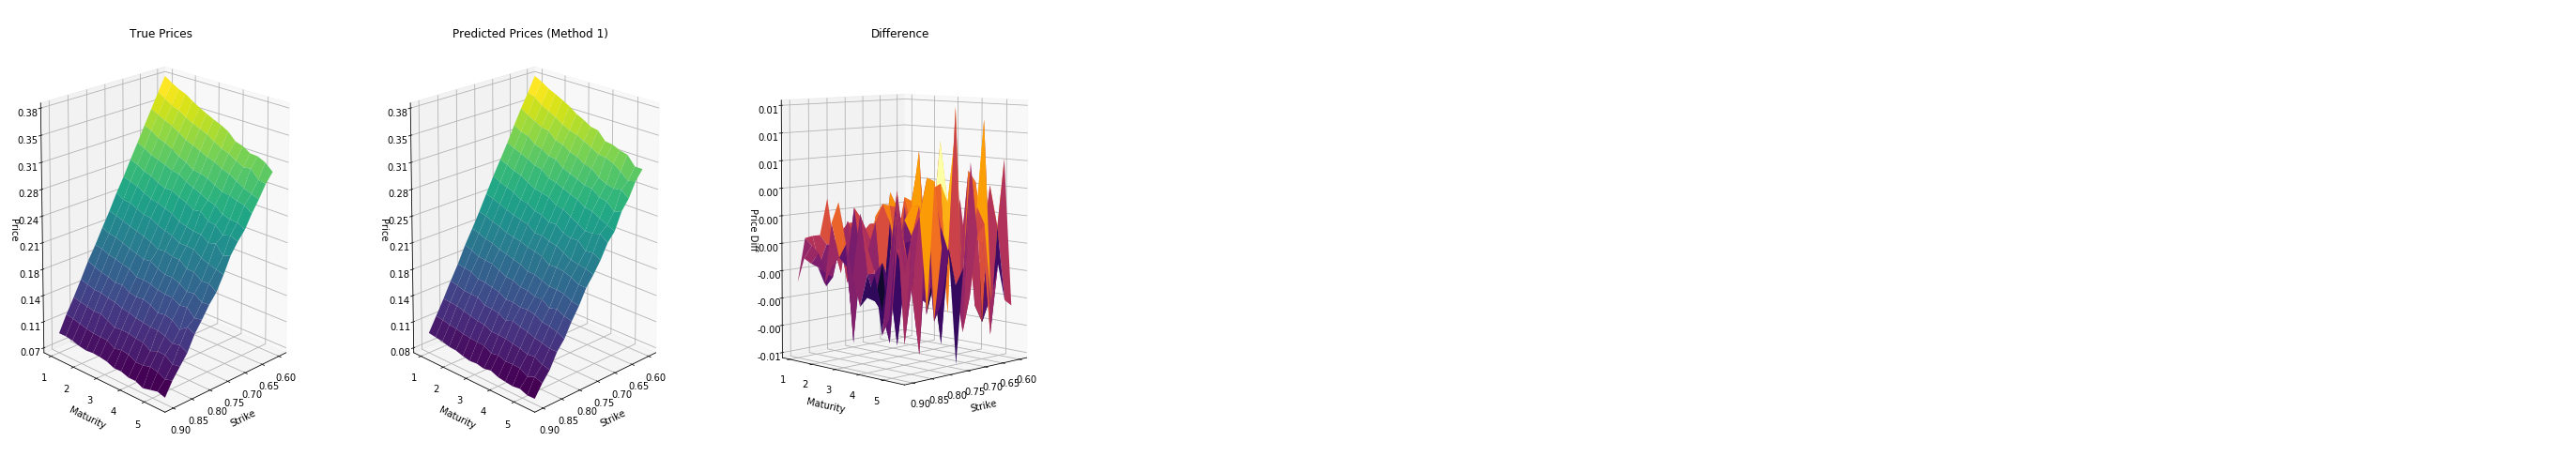

In [93]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

fig = plt.figure(figsize=(20, 9))

T_ = np.zeros((num_maturities,num_strikes))
K_ = np.zeros((num_maturities,num_strikes))
for i in range(num_strikes):
    for j in range(num_maturities):
        T_[j,i] = maturities[j]
for j in range(num_maturities):   
    for i in range(num_strikes):
        K_[j,i] = strikes[i]

ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X=K_, Y=T_, Z=prices_true, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax1.zaxis.set_major_locator(LinearLocator(10))
ax1.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax1.set_xlabel('Strike')
ax1.set_ylabel('Maturity')
ax1.set_zlabel('Price')
ax1.set_title('True Prices')
ax1.view_init(15, 45)

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X=K_, Y=T_, Z=prices_pred, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax2.zaxis.set_major_locator(LinearLocator(10))
ax2.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax2.set_xlabel('Strike')
ax2.set_ylabel('Maturity')
ax2.set_zlabel('Price')
ax2.set_title('Predicted Prices (Method 1)')
ax2.view_init(15, 45)


ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X=K_, Y=T_, Z=prices_true-prices_pred, rstride=1, cstride=1, cmap='inferno', edgecolor='none')
ax3.zaxis.set_major_locator(LinearLocator(10))
ax3.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax3.set_xlabel('Strike')
ax3.set_ylabel('Maturity')
ax3.set_zlabel('Price Diff')
ax3.set_title('Difference')
ax3.view_init(5, 45)
"""
ax3 = fig.add_subplot(133)
ax3.imshow(prices_true-prices_pred,cmap='Blues_r')
ax3.set_xticks(np.linspace(0,num_strikes-1,num_strikes))
ax3.set_xticklabels(np.around(strikes,decimals=1))
ax3.set_yticks(np.linspace(0,num_maturities-1,num_maturities))
ax3.set_yticklabels(np.around(maturities,decimals=1))
"""
plt.savefig('prices_dnn_m2.pdf') 
plt.show()

In [94]:
mean_err = np.mean(np.mean(np.abs(prices_true-prices_pred),axis=0),axis=0)
mean_err_init = np.mean(np.mean(np.abs(prices_true-prices_trash),axis=0),axis=0)
mean_true_price = np.mean(np.mean(np.abs(prices_true),axis=0),axis=0)
print("MSE: ",mean_err)
print("MSE Init: ",mean_err_init)
print("Percent of avg True Price: ",mean_err/mean_true_price*100)

MSE:  0.0018077524263122357
MSE Init:  0.0018246034427401435
Percent of avg True Price:  0.8495622941156543


In [95]:
num_thetas = 5

def reverse_transform_theta(theta_scaled):
    X = np.zeros(theta_scaled.shape)
    for i in range(num_model_parameters):
        X[:,i] = theta_scaled[:,i]*(model_bounds[i][1]-model_bounds[i][0]) + model_bounds[i][0]
    return X

thetas_true = reverse_transform_theta(uniform.rvs(size=(num_thetas,num_model_parameters)))

In [19]:
def NNgradientpred(theta,maturities,strikes):
        x = np.zeros((1,num_input_parameters))
        
        x[0,0:3] = theta
       
        grad = np.zeros((num_model_parameters,num_maturities,num_strikes))
        
        delta = 0.000001
        for i in range(num_model_parameters):
            h = np.zeros((1,num_input_parameters))
            h[0,i] = delta
            for j in range(num_maturities):
                for k in range(num_strikes):
                    x[0,3] = maturities[j]
                    x[0,4] = strikes[k]
                    #two point gradient
                    #grad[i] = (sess.run(outputs,feed_dict={X: x+h}) - sess.run(outputs,feed_dict={X: x-h}))/2/delta

                    #four point gradient
                    grad[i,j,k] = (-sess.run(outputs,feed_dict={X: x+2*h})+8*sess.run(outputs,feed_dict={X: x+h})-8*sess.run(outputs,feed_dict={X: x-h}) +sess.run(outputs,feed_dict={X: x-2*h}))/12/delta

        return np.mean(np.mean(grad,axis=1),axis=1)

with tf.Session() as sess:                          
        saver.restore(sess, "./models/sabr_dnn_m2")
        x = uniform.rvs(size=(1,5))
        %timeit sess.run(outputs,feed_dict={X: x})
        theta = x[0,0:3]
        %timeit NNgradientpred(theta,maturities,strikes)

INFO:tensorflow:Restoring parameters from ./models/sabr_dnn_m2
504 µs ± 65.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.28 s ± 51.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
